# Spectragram Positional Embedding

In [1]:
import os
import sys
import cv2
import pickle

from __future__ import print_function, division
from astropy.io          import fits
from astropy             import units as u
from astropy.coordinates import SkyCoord

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR
import os
import argparse

import glob
import pickle

C:\Users\Administrator\.conda\envs\torch1.12.1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preparation

In [2]:
print(os.getcwd())

C:\Users\Administrator\Desktop\HI2\HI


In [3]:
training_data_kok14_galfa = os.path.join(os.getcwd(),"data", "other", "training_data_kok14_galfa.pickle")

In [4]:
training_data_kok14_galfa = os.path.join(os.getcwd(),"data", "other", "training_data_kok14_galfa.pickle")
data = pickle.load(open(training_data_kok14_galfa, 'rb'))

# training data
X_train = data['X_train']
Y_train = data['Y_train']
# Observed test data
X_test = data['X_test']
Y_test = data['Y_test']

In [5]:
print("x_train = ", X_train.shape)
print("Y_train = ", Y_train.shape)
print("X_test = ", X_test.shape)
print("Y_test = ", Y_test.shape)

x_train =  (38781, 414)
Y_train =  (38781, 2)
X_test =  (58, 414)
Y_test =  (58, 2)


## Split train, validation and testing set from X_train and Y_train.

In [6]:
x_train = X_train[0:23268, :]
y_train = Y_train[0:23268, :]

x_val = X_train[23268: 31024, :]
y_val = Y_train[23268: 31024, :]

x_test = X_train[31024:, :]
y_test = Y_train[31024:, :]

In [7]:
print("x_train=",x_train.shape, ", y_train=", y_train.shape)
print("x_val=",x_val.shape, ", y_val=", y_val.shape)
print("x_test=",x_test.shape, ", y_test=", y_test.shape)

x_train= (23268, 414) , y_train= (23268, 2)
x_val= (7756, 414) , y_val= (7756, 2)
x_test= (7757, 414) , y_test= (7757, 2)


# Display few training samples

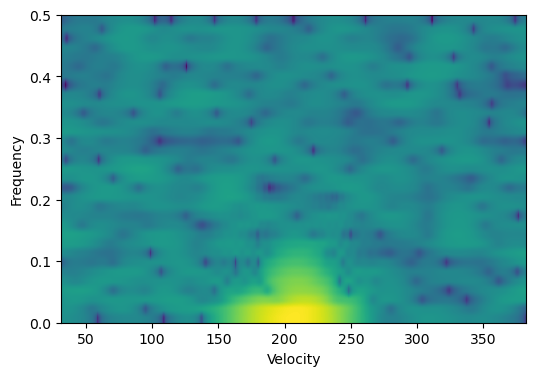

In [8]:
x = x_train[0, :]

plt.figure(figsize=(6,4))
plt.xlabel("Velocity")
plt.ylabel("Frequency")
ws = 64
spectrum, freqs,t,im = plt.specgram(x, Fs=1, NFFT = ws, noverlap=ws-1)
torch_tensor = torch.from_numpy(spectrum)
#print(spectrum.shape)
#plt.show(10*np.log10(torch_tensor))
plt.show()

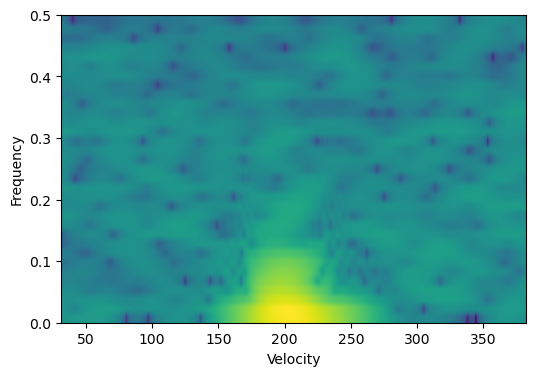

In [9]:
x = x_train[1000, :]

plt.figure(figsize=(6,4))
plt.xlabel("Velocity")
plt.ylabel("Frequency")
ws = 64
spectrum, freqs,t,im = plt.specgram(x, Fs=1, NFFT = ws, noverlap=ws-1)
torch_tensor = torch.from_numpy(spectrum)
#print(spectrum.shape)
#plt.show(10*np.log10(torch_tensor))
plt.show()

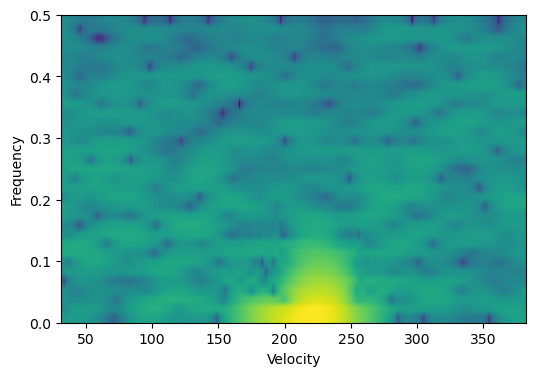

In [10]:
x = x_train[10000, :]

plt.figure(figsize=(6,4))
plt.xlabel("Velocity")
plt.ylabel("Frequency")
ws = 64
spectrum, freqs,t,im = plt.specgram(x, Fs=1, NFFT = ws, noverlap=ws-1)
torch_tensor = torch.from_numpy(spectrum)
#print(spectrum.shape)
#plt.show(10*np.log10(torch_tensor))
plt.show()

# Data Loader

In [12]:
# data loader 
class HI_dataset(torch.utils.data.Dataset):
    def __init__(self, x_path, y, transform=None, target_transform=None):
        self.y = y
        self.x_path = x_path
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.y[:,0])
    
    def __getitem__(self, idx):
        #print("idx=",idx)
        filename = f'{idx}.jpg'
        spectra = cv2.imread(os.path.join(self.x_path,filename))
        spectra = cv2.cvtColor(spectra, cv2.COLOR_BGR2RGB)
        label = self.y[idx,:].reshape(1, -1)
        #label = label.view(1, -1)
        #print(spectra.shape)
        if self.transform:
            spectra = self.transform(spectra)
            spectra = spectra.view(3,spectra.shape[0], spectra.shape[1])
        if self.target_transform:
            label = self.target_transform(label)
        return spectra, label

In [13]:
# transform to tenor 
class ToTensor_x():
    def __call__(self, sample):
        x = torch.from_numpy(sample)
        return x

In [14]:
# transform to tenor 
class ToTensor_y():
    def __call__(self, sample):
        x = torch.from_numpy(sample)
        x =x.squeeze()
        return x

In [31]:
# initialize dataset
train_path = os.path.join(os.getcwd(),"data", "image", "spe", "x_train")
validate_path = os.path.join(os.getcwd(),"data", "image", "spe", "x_vali")
test_path = os.path.join(os.getcwd(),"data","image", "spe", "x_test")
#print(data['Y_train'].shape)
#print(data['Y_train'].shape[0]-6000)
dataset_train = HI_dataset(x_path = train_path, y = y_train, transform=ToTensor_x(), target_transform=ToTensor_y())
dataset_test = HI_dataset(x_path =test_path, y=y_test, transform=ToTensor_x(), target_transform=ToTensor_y())
dataset_validate = HI_dataset(x_path =validate_path, y=y_val, transform=ToTensor_x(), target_transform=ToTensor_y())

In [32]:
# initialize data loader
batch_size =20 #20
train_loader = torch.utils.data.DataLoader(dataset = dataset_train, batch_size = batch_size, shuffle =False)
valid_loader = torch.utils.data.DataLoader(dataset = dataset_validate, batch_size = batch_size, shuffle =False)
test_loader = torch.utils.data.DataLoader(dataset = dataset_test, batch_size = batch_size, shuffle =False)

In [33]:
# test data loader
val = iter(valid_loader)
A,B = next(val)
print(A.shape)
print(B.shape)

torch.Size([20, 3, 400, 600])
torch.Size([20, 2])


# CNN

In [34]:
from torchvision.models import mnasnet0_5
model = mnasnet0_5(pretrained=True)
#model.layers[0] = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
model.classifier[1] = nn.Linear(in_features=1280, out_features=2, bias=True)

In [35]:
# number of parameter
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    #print(table)
    #print(f"Total Trainable Params: {total_params}")
    return total_params
print("number of parameter:", count_parameters(model))

number of parameter: 940074


##  Training setting

In [38]:
# training setting

lr = 0.1
#lr = 0.0005
num_epoch = 80
num_step = len(X_train)/batch_size
#print(len(X_train), batch_size, num_step)
loss_function = nn.MSELoss()
best_err = 100000
optimizer = torch.optim.SGD(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones = [num_epoch*0.8], gamma=0.1, last_epoch=-1, verbose=False)
device = torch.device('cuda:0')
model.to(device)

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(8, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(24, 24,

In [39]:
training_MES = []
vaidation_MSE = []
testing_MSE = []

In [40]:
# train 
def train(epoch):
    global training_MES
    print('\nEpoch: %d' % epoch)
    train_loss = 0
    total = 0
    for index, (inputs, values) in enumerate(train_loader):
        inputs = inputs.float()
        values = values.float()
        inputs, values = inputs.to(device), values.to(device)
        # forward 
        outputs = model(inputs)
        #print("output = ", outputs)
        #target.view(1, -1)
        #outputs = outputs.view(outputs[0], 1, outputs[1])
        #print("otput shape=",outputs.shape)
       # print("values shape = ", values.shape)
        loss = loss_function(outputs, values)
        #print("loss = ", loss)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print info
        train_loss = train_loss + (loss.item()*values.size(0)) 
        total += values.size(0)
        if (index+1)%500==0:
            print(f'epoch: {epoch+1}/{num_epoch}, step: {index+1}/{num_step}, avg_loss = {train_loss/total}')
            #print(f'truth = {values}, preditction = {outputs}, error = {loss.item()}')
            #print("outputs = ", outputs)
            #print(model.conv1.weight.grad) 
    training_MES.append(train_loss/total)
    print("total loss = ", train_loss)
    print("total = ",total)

In [41]:
def validation(epoch):
    global best_err
    global vaidation_MSE
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(valid_loader):
            inputs = inputs.float() 
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward 
            outputs = model(inputs)
            #outputs = outputs.view(outputs[0], 1, outputs[1])
            loss = loss_function(outputs, values)
            test_loss = test_loss + (loss.item()*values.size(0))
            total += values.size(0)
    vaidation_MSE.append(test_loss/total)
    # Save checkpoint.
    error =  test_loss / total
    print('avg_validate_accuracy=', error)
    if error < best_err:
        print('best_err:', error, 'Saving..')
        state = {'net': model.state_dict(),
                 'err': error,
                 'optimizer_state_dict': optimizer.state_dict(),
                 'epoch': epoch}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/Spectragram.pth')
        best_err = error

In [42]:
def test(epoch):
    global best_err
    global testing_MSE
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(test_loader):
            inputs = inputs.float()
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward 
            outputs = model(inputs)
            #outputs = outputs.view(outputs[0], 1, outputs[1])
            loss = loss_function(outputs, values)
            test_loss =test_loss+ (loss.item()* values.size(0))
            total += values.size(0)
        testing_MSE.append(test_loss/total)
        print(f'Test performance in epoch {epoch}: avg_error = {test_loss/total}')

## Start Training

In [43]:
# start training
for epoch in range(num_epoch):
    train(epoch)
    validation(epoch)
    scheduler.step()
    test(epoch)


Epoch: 0
epoch: 1/80, step: 500/1939.05, avg_loss = 0.016518338229972868
epoch: 1/80, step: 1000/1939.05, avg_loss = 0.014290641821455211
total loss =  325.7983359331265
total =  23268
avg_validate_accuracy= 0.012196956963680373
best_err: 0.012196956963680373 Saving..
Test performance in epoch 0: avg_error = 0.011622588229204164

Epoch: 1
epoch: 2/80, step: 500/1939.05, avg_loss = 0.010942185303661972
epoch: 2/80, step: 1000/1939.05, avg_loss = 0.01074501653306652
total loss =  251.56236477894709
total =  23268
avg_validate_accuracy= 0.011245960506474644
best_err: 0.011245960506474644 Saving..
Test performance in epoch 1: avg_error = 0.010706505327826119

Epoch: 2
epoch: 3/80, step: 500/1939.05, avg_loss = 0.010184507183963434
epoch: 3/80, step: 1000/1939.05, avg_loss = 0.010061682036262938
total loss =  235.8956920313649
total =  23268
avg_validate_accuracy= 0.010856987345078024
best_err: 0.010856987345078024 Saving..
Test performance in epoch 2: avg_error = 0.010190368532741616

Epo

## Plot training process

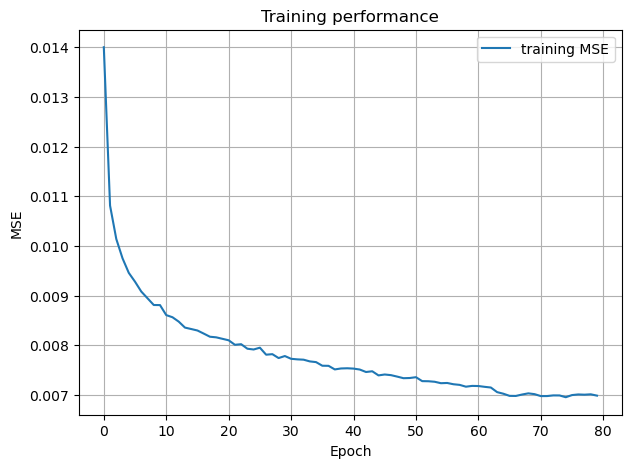

In [44]:
x = training_MES
plt.figure(figsize=(7,5))
plt.title('Training performance')
plt.plot(x, label='training MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.savefig(os.path.join(os.getcwd(),"training_process")+"\\spectragram_training.jpg")
plt.show()

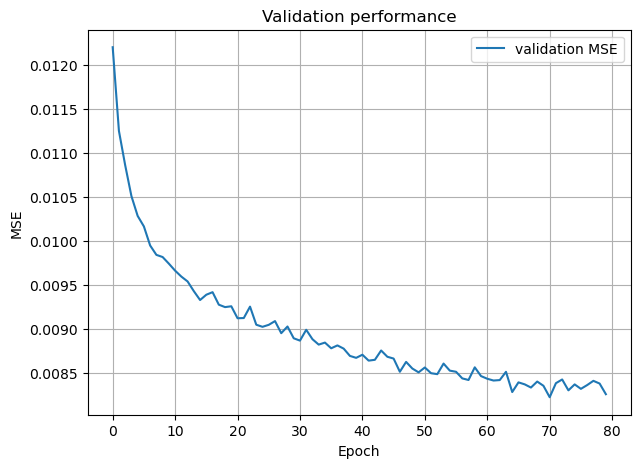

In [45]:
x = vaidation_MSE
plt.figure(figsize=(7,5))
plt.title('Validation performance')
plt.plot(x, label='validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.savefig(os.path.join(os.getcwd(),"training_process")+"\\spectragram_validation.jpg")
plt.show()

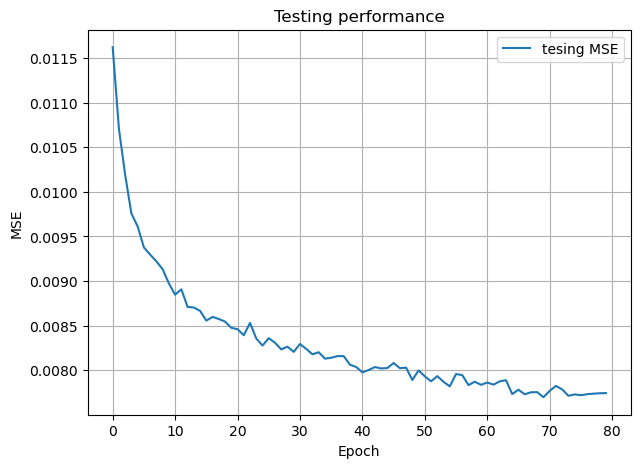

In [46]:
x = testing_MSE
plt.figure(figsize=(7,5))
plt.title('Testing performance')
plt.plot(x, label='tesing MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.savefig(os.path.join(os.getcwd(),"training_process")+"\\spectragram_testing.jpg")
plt.show()

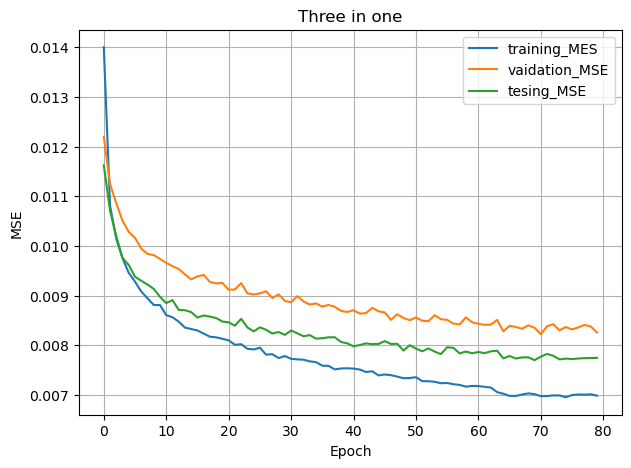

In [47]:
x1 = training_MES
x2 = vaidation_MSE
x3 = testing_MSE
plt.figure(figsize=(7,5))
plt.title('Three in one')
plt.plot(x1, label='training_MES')
plt.plot(x2, label='vaidation_MSE')
plt.plot(x3, label='tesing_MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.savefig(os.path.join(os.getcwd(),"training_process")+"\\spectragram_3in1.jpg")
plt.show()

## Save into excel

In [48]:
x1 = np.array(training_MES).reshape(1, -1)
x2 = np.array(vaidation_MSE).reshape(1, -1)
x3 = np.array(testing_MSE).reshape(1, -1)
three = np.vstack((x1,x2,x3))
df = pd.DataFrame(three).T
df.to_excel(excel_writer = os.path.join(os.getcwd(),"training_process") + "\\spectragram_process.xlsx")

## Model testing

In [49]:
# model testing

model = mnasnet0_5(pretrained=False)
model.classifier[1] = nn.Linear(in_features=1280, out_features=2, bias=True)
model.to(device)
checkpoint = torch.load('./checkpoint/Spectragram.pth')
model.load_state_dict(checkpoint['net'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
#loss = checkpoint['loss']

test(epoch)

C:\Users\Administrator\.conda\envs\torch1.12.1\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Administrator\.conda\envs\torch1.12.1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Test performance in epoch 70: avg_error = 0.007720467121773399
